In [1]:
import zipfile
from zipfile import ZipFile
import pandas as pd
import numpy as np
import copy
import re
import netCDF4 as nc
from matplotlib import pyplot as plt
import xarray as xr
import os
# from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import warnings
warnings.filterwarnings("ignore")

In [2]:
#station files and their coords converted to decimals
# Station numbers can be seen in from GTA_waterstations.csv which are waterstations within the region
# Gathered from https://wateroffice.ec.gc.ca/search/historical_e.html
stationfilesinitial={'02ec008':['''44°15'38" N''','''79°20'38" W'''],'02ec009':['''44°05'41" N''','''79°29'22" W'''],'02ec011':['''44°23'49" N''','''79°04'15" W'''],
              '02ec018':['''44°16'03" N''','''79°11'40" W'''],'02ec021':['''44°08'17" N''','''79°06'45" W'''],'02GA031':['''43°34'34" N''','''80°06'32" W'''],
              '02HB001':['''43°50'09" N''','''80°01'22" W'''],'02HB004':['''43°29'57" N''','''79°46'36" W'''],'02HB005':['''43°30'50" N''','''79°52'47" W'''],
              '02HB008':['''43°38'47" N''','''79°51'58" W'''],'02HB011':['''43°26'12" N''','''79°51'51" W'''],'02HB012':['''43°18'02" N''','''79°52'08" W'''],
              '02HB013':['''43°53'28" N''','''80°03'44" W'''],'02HB018':['''43°46'24" N''','''79°55'36" W'''],'02HB024':['''43°37'45" N''','''80°00'37" W'''],
              '02HB025':['''43°38'51" N''','''79°51'21" W'''],'02HB027':['''43°25'17" N''','''79°42'11" W'''],'02HB029':['''43°34'56" N''','''79°42'31" W'''],
              '02HB030':['''43°35'32" N''','''79°37'26" W'''],'02HB034':['''43°18'21" N''','''79°51'47" W'''],'02HC003':['''43°41'56" N''','''79°31'13" W'''],
              '02HC005':['''43°44'24" N''','''79°24'11" W'''],'02HC009':['''43°47'24" N''','''79°35'03" W'''],'02HC013':['''43°46'41" N''','''79°11'29" W'''],
              '02HC017':['''43°41'29" N''','''79°45'33" W'''],'02HC018':['''43°52'31" N''','''78°57'37" W'''],'02HC019':['''43°53'28" N''','''79°03'33" W'''],
              '02HC022':['''43°51'30" N''','''79°14'00" W'''],'02HC023':['''43°53'16" N''','''79°43'03" W'''],'02HC024':['''43°41'09" N''','''79°21'41" W'''],
              '02HC025':['''43°48'40" N''','''79°37'39" W'''],'02HC027':['''43°40'27" N''','''79°30'15" W'''],'02HC028':['''43°54'28" N''','''79°12'58" W'''],
              '02HC030':['''43°36'06" N''','''79°33'22" W'''],'02HC031':['''43°45'30" N''','''79°40'44" W'''],'02HC032':['''43°54'10" N''','''79°36'46" W'''],
              '02HC033':['''43°38'50" N''','''79°31'10" W'''],'02HC038':['''43°54'56" N''','''79°10'46" W'''],'02HC047':['''43°55'42" N''','''79°49'22" W'''],
              '02HC049':['''43°50'56" N''','''79°03'22" W'''],'02HC051':['''43°55'28" N''','''79°50'04" W'''],'02HC053':['''43°55'32" N''','''79°16'55" W'''],
              '02HC054':['''43°57'32" N''','''78°57'35" W'''],'02HC055':['''43°55'55" N''','''78°59'18" W'''],'02HC056':['''43°49'35" N''','''79°26'17" W'''],
              '02HC058':['''43°45'11" N''','''79°14'01" W'''],'02HD006':['''43°55'17" N''','''78°42'07" W'''],'02HD009':['''43°55'48" N''','''78°37'07" W'''],
              '02HD013':['''43°53'19" N''','''78°49'29" W'''],'02HD021':['''44°00'20" N''','''78°38'32" W'''],'02HD023':['''43°58'44" N''','''78°40'49" W'''],
              '02HG002':['''44°05'12" N''','''79°00'21" W'''],'02HG003':['''44°07'54" N''','''78°49'44" W''']}
for key, value in stationfilesinitial.items():
    lat=value[0]
    long=value[1]
    deg, minutes, seconds, direction =  re.split('[°\'"]', lat)
    value[0]=(float(deg) + float(minutes)/60 + float(seconds)/(60*60))
    deg, minutes, seconds, direction =  re.split('[°\'"]', long)
    value[1]=(float(deg) + float(minutes)/60 + float(seconds)/(60*60)) * (-1)
    
#opening original plot with regular coords - additionally plotting on scatter plot where it is
stationfiles=copy.deepcopy(stationfilesinitial)


In [3]:
basedir=r'Path\To\File\Streamflow Data'

foldernames=[]
for file in os.listdir(basedir):
    d = os.path.join(basedir, file)
    foldernames.append(file)
folderpath=[]
for file in foldernames:
    folderpath.append(os.path.join(basedir, file))
# getting file path locations and whatnot

In [4]:
all_dfs=pd.DataFrame()
for i in folderpath:
    temp=pd.read_csv(i)
    all_dfs=all_dfs.append(temp,ignore_index=False)

In [5]:
all_dfs=all_dfs.reset_index()

In [6]:
Daily_Discharge=pd.DataFrame()
# Compiling data (some datasets had string and int classifications). Get the data for each available day, for each station
Daily_Discharge=Daily_Discharge.append(all_dfs.loc[all_dfs['level_1'] == '1'])
Daily_Discharge=Daily_Discharge.append(all_dfs.loc[all_dfs['level_1'] == 1])

In [7]:
Daily_Water_Level=pd.DataFrame()
# Water level is not considered later on
Daily_Water_Level=Daily_Water_Level.append(all_dfs.loc[all_dfs['level_1'] == '2'])
Daily_Water_Level=Daily_Water_Level.append(all_dfs.loc[all_dfs['level_1'] == 2])

In [8]:
Daily_Discharge['level_2']=pd.to_datetime(Daily_Discharge['level_2'])
Daily_Discharge['level_3']=Daily_Discharge['level_3'].astype(float)
Daily_Discharge_Modified=pd.DataFrame()
Daily_Discharge_Modified['StationNames']=Daily_Discharge['level_0']
Daily_Discharge_Modified['Outflow']=Daily_Discharge['level_3']
Daily_Discharge_Modified['Date']=Daily_Discharge['level_2']

In [9]:
Daily_Water_Level_Modified=pd.DataFrame()
Daily_Water_Level_Modified['StationNames']=Daily_Water_Level['level_0']
Daily_Water_Level_Modified['Water_Level']=Daily_Water_Level['level_3']
Daily_Water_Level_Modified['Date']=Daily_Water_Level['level_2']
Daily_Water_Level_Modified=Daily_Water_Level_Modified.dropna()

In [10]:
Daily_Discharge_Modified

,StationNames,Outflow,Date
1,02EC021,1.010,2006-04-01
2,02EC021,0.703,2006-04-02
3,02EC021,0.730,2006-04-03
4,02EC021,0.742,2006-04-04
5,02EC021,0.636,2006-04-05
...,...,...,...
1151175,02HB004,1.830,2021-12-27
1151176,02HB004,1.330,2021-12-28
1151177,02HB004,1.210,2021-12-29
1151178,02HB004,1.230,2021-12-30


In [ ]:
Daily_Discharge_Modified

In [ ]:
# Did additional testing on the data before saving

In [11]:
# Daily_Discharge_Modified.to_excel('Path\to\File\Streamflow2023.xlsx')
# Daily_Water_Level_Modified.to_excel('Path\to\File\WaterLevel2023.xlsx')

In [12]:
# CESM2 100 km
# CMCC-CM2-SR5 100 km
# CMCC-ESM2
# NorESM2-MM 100 km

In [13]:
Daily_Discharge_Modified

,StationNames,Outflow,Date
1,02EC021,1.010,2006-04-01
2,02EC021,0.703,2006-04-02
3,02EC021,0.730,2006-04-03
4,02EC021,0.742,2006-04-04
5,02EC021,0.636,2006-04-05
...,...,...,...
1151175,02HB004,1.830,2021-12-27
1151176,02HB004,1.330,2021-12-28
1151177,02HB004,1.210,2021-12-29
1151178,02HB004,1.230,2021-12-30


In [14]:
# Get the cmip data, see how the compare to the data we extracted
CMIPValues_CMCC_CM2_SR5_585=pd.read_excel('D:\Mosq Proj Data\CMIP Data\Merged Datasets\CMIP Modified Datasets\CMIPValues_CMCC_CM2_SR5_585_Fulldataset.xlsx')
CMIPValues_CMCC_CM2_SR5_245=pd.read_excel('D:\Mosq Proj Data\CMIP Data\Merged Datasets\CMIP Modified Datasets\CMIPValues_CMCC_CM2_SR5_245_Fulldataset.xlsx')

CMIPValues_CESM2_245=pd.read_excel('D:\Mosq Proj Data\CMIP Data\Merged Datasets\CMIP Modified Datasets\CMIPValues_CESM2_245_Fulldataset.xlsx')
CMIPValues_CESM2_585=pd.read_excel('D:\Mosq Proj Data\CMIP Data\Merged Datasets\CMIP Modified Datasets\CMIPValues_CESM2_585_Fulldataset.xlsx')

CMIPValues_NorESM2_MM_585=pd.read_excel('D:\Mosq Proj Data\CMIP Data\Merged Datasets\CMIP Modified Datasets\CMIPValues_NorESM2_MM_585_Fulldataset.xlsx')
CMIPValues_NorESM2_MM_245=pd.read_excel('D:\Mosq Proj Data\CMIP Data\Merged Datasets\CMIP Modified Datasets\CMIPValues_NorESM2_MM_245_Fulldataset.xlsx')

CMIPValues_CMCC_ESM2_585=pd.read_excel('D:\Mosq Proj Data\CMIP Data\Merged Datasets\CMIP Modified Datasets\CMIPValues_CMCC_ESM2_585_Fulldataset.xlsx')
CMIPValues_CMCC_ESM2_245=pd.read_excel('D:\Mosq Proj Data\CMIP Data\Merged Datasets\CMIP Modified Datasets\CMIPValues_CMCC_ESM2_245_Fulldataset.xlsx')


In [15]:
WaterStation_Data=pd.read_csv(r'D:\Mosq Proj Data\GTA_waterstations.csv')
WaterStation_Data=WaterStation_Data.drop(columns=['Unnamed: 0','V1','V2','optional','Unnamed: 6'])

Daily_Discharge_Modified=pd.merge(Daily_Discharge_Modified,WaterStation_Data,how="left",left_on="StationNames",right_on="OntarioStations.STATION_NUMBER")
Daily_Discharge_Modified=Daily_Discharge_Modified.drop(columns=['OntarioStations.STATION_NUMBER'])

# Converting outflow cubic meters per day from cubic meters per second. Don't use this outflow later on
Daily_Discharge_Modified['Outflow (m^3/s)']=Daily_Discharge_Modified['Outflow']
Daily_Discharge_Modified['Outflow']=Daily_Discharge_Modified['Outflow']*24*60*60
Daily_Discharge_Modified['Drainage Area (m^2)']=Daily_Discharge_Modified['Drainage Area (Km^2)']*1000**2
Daily_Discharge_Modified['Water Level']=Daily_Discharge_Modified['Outflow']/Daily_Discharge_Modified['Drainage Area (m^2)']

In [16]:
Daily_Discharge_Modified

,StationNames,Outflow,Date,Drainage Area (Km^2),Outflow (m^3/s),Drainage Area (m^2),Water Level
0,02EC021,87264.0,2006-04-01,40.6,1.010,40600000.0,0.002149
1,02EC021,60739.2,2006-04-02,40.6,0.703,40600000.0,0.001496
2,02EC021,63072.0,2006-04-03,40.6,0.730,40600000.0,0.001553
3,02EC021,64108.8,2006-04-04,40.6,0.742,40600000.0,0.001579
4,02EC021,54950.4,2006-04-05,40.6,0.636,40600000.0,0.001353
...,...,...,...,...,...,...,...
891976,02HB004,158112.0,2021-12-27,193.0,1.830,193000000.0,0.000819
891977,02HB004,114912.0,2021-12-28,193.0,1.330,193000000.0,0.000595
891978,02HB004,104544.0,2021-12-29,193.0,1.210,193000000.0,0.000542
891979,02HB004,106272.0,2021-12-30,193.0,1.230,193000000.0,0.000551


In [17]:
StreamflowData2=Daily_Discharge_Modified.drop(columns=['Drainage Area (m^2)','Drainage Area (Km^2)','StationNames'])
StreamflowData2=StreamflowData2.groupby(['Date']).sum()
StreamflowData2 = StreamflowData2.reset_index()


In [31]:
StreamflowData2[StreamflowData2['Date'].dt.year>2001]

,Date,Outflow (m^3/s)
31651,2002-01-01,24.757
31652,2002-01-02,24.229
31653,2002-01-03,24.547
31654,2002-01-04,24.615
31655,2002-01-05,24.327
...,...,...
38951,2021-12-27,81.250
38952,2021-12-28,69.122
38953,2021-12-29,62.662
38954,2021-12-30,60.416


In [19]:
# see how this 'water level' matches up to cmip datasets
StreamflowData=Daily_Discharge_Modified.drop(columns=['Drainage Area (m^2)','Drainage Area (Km^2)','StationNames'])
StreamflowData=StreamflowData.groupby(['Date']).mean()
StreamflowData = StreamflowData.reset_index()

In [20]:
CMIPValues_CMCC_CM2_SR5_585['Water_Level']=CMIPValues_CMCC_CM2_SR5_585['Runoff']*24*60*60/(100**2*1000**2)
CMIPValues_CMCC_CM2_SR5_245['Water_Level']=CMIPValues_CMCC_CM2_SR5_245['Runoff']*24*60*60/(100**2*1000**2)
CMIPValues_CESM2_245['Water_Level']=CMIPValues_CESM2_245['Runoff']*24*60*60/(100**2*1000**2)
CMIPValues_CESM2_585['Water_Level']=CMIPValues_CESM2_585['Runoff']*24*60*60/(100**2*1000**2)
CMIPValues_NorESM2_MM_585['Water_Level']=CMIPValues_NorESM2_MM_585['Runoff']*24*60*60/(100**2*1000**2)
CMIPValues_NorESM2_MM_245['Water_Level']=CMIPValues_NorESM2_MM_245['Runoff']*24*60*60/(100**2*1000**2)
CMIPValues_CMCC_ESM2_585['Water_Level']=CMIPValues_CMCC_ESM2_585['Runoff']*24*60*60/(100**2*1000**2)
CMIPValues_CMCC_ESM2_245['Water_Level']=CMIPValues_CMCC_ESM2_245['Runoff']*24*60*60/(100**2*1000**2)

In [21]:
StreamflowData['Year']=StreamflowData['Date'].dt.year
StreamflowData['Day']=StreamflowData['Date'].dt.day
StreamflowData['Month']=StreamflowData['Date'].dt.month
StreamflowData=StreamflowData.drop(columns=['Date'])

In [22]:
# Gotta make all this code more concise, really repetetive for no reason
CMCC_CM2_SR5_585_and_Observed=pd.merge(StreamflowData, CMIPValues_CMCC_CM2_SR5_585, how = 'inner', left_on = ['Year', 'Month', 'Day'], right_on = ['Year', 'Month', 'Day'])
CMCC_CM2_SR5_585_and_Observed=CMCC_CM2_SR5_585_and_Observed.dropna()
CMCC_CM2_SR5_585_and_Observed=CMCC_CM2_SR5_585_and_Observed[CMCC_CM2_SR5_585_and_Observed['Year']>2001]
CMCC_CM2_SR5_585_and_Observed=CMCC_CM2_SR5_585_and_Observed[CMCC_CM2_SR5_585_and_Observed['Year']<2015]
CMCC_CM2_SR5_585_and_Observed_Monthly=CMCC_CM2_SR5_585_and_Observed.groupby(pd.Grouper(key='Date', freq='M')).mean() 
CMCC_CM2_SR5_585_and_Observed_Monthly=CMCC_CM2_SR5_585_and_Observed_Monthly.reset_index()
CMCC_CM2_SR5_585_and_Observed_Weekly=CMCC_CM2_SR5_585_and_Observed.groupby(pd.Grouper(key='Date', freq='W')).mean() 
CMCC_CM2_SR5_585_and_Observed_Weekly=CMCC_CM2_SR5_585_and_Observed_Weekly.reset_index()

CMCC_CM2_SR5_245_and_Observed=pd.merge(StreamflowData, CMIPValues_CMCC_CM2_SR5_245, how = 'inner', left_on = ['Year', 'Month', 'Day'], right_on = ['Year', 'Month', 'Day'])
CMCC_CM2_SR5_245_and_Observed=CMCC_CM2_SR5_245_and_Observed.dropna()
CMCC_CM2_SR5_245_and_Observed=CMCC_CM2_SR5_245_and_Observed[CMCC_CM2_SR5_245_and_Observed['Year']>2001]
CMCC_CM2_SR5_245_and_Observed=CMCC_CM2_SR5_245_and_Observed[CMCC_CM2_SR5_245_and_Observed['Year']<2015]
CMCC_CM2_SR5_245_and_Observed_Monthly=CMCC_CM2_SR5_245_and_Observed.groupby(pd.Grouper(key='Date', freq='M')).mean() 
CMCC_CM2_SR5_245_and_Observed_Monthly=CMCC_CM2_SR5_245_and_Observed_Monthly.reset_index()
CMCC_CM2_SR5_245_and_Observed_Weekly=CMCC_CM2_SR5_245_and_Observed.groupby(pd.Grouper(key='Date', freq='W')).mean() 
CMCC_CM2_SR5_245_and_Observed_Weekly=CMCC_CM2_SR5_245_and_Observed_Weekly.reset_index()

CESM2_585_and_Observed=pd.merge(StreamflowData, CMIPValues_CESM2_585, how = 'inner', left_on = ['Year', 'Month', 'Day'], right_on = ['Year', 'Month', 'Day'])
CESM2_585_and_Observed=CESM2_585_and_Observed.dropna()
CESM2_585_and_Observed=CESM2_585_and_Observed[CESM2_585_and_Observed['Year']>2001]
CESM2_585_and_Observed=CESM2_585_and_Observed[CESM2_585_and_Observed['Year']<2015]
CESM2_585_and_Observed_Monthly=CESM2_585_and_Observed.groupby(pd.Grouper(key='Date', freq='M')).mean() 
CESM2_585_and_Observed_Monthly=CESM2_585_and_Observed_Monthly.reset_index()
CESM2_585_and_Observed_Weekly=CESM2_585_and_Observed.groupby(pd.Grouper(key='Date', freq='W')).mean() 
CESM2_585_and_Observed_Weekly=CESM2_585_and_Observed_Weekly.reset_index()

CESM2_245_and_Observed=pd.merge(StreamflowData, CMIPValues_CESM2_245, how = 'inner', left_on = ['Year', 'Month', 'Day'], right_on = ['Year', 'Month', 'Day'])
CESM2_245_and_Observed=CESM2_245_and_Observed.dropna()
CESM2_245_and_Observed=CESM2_245_and_Observed[CESM2_245_and_Observed['Year']>2001]
CESM2_245_and_Observed=CESM2_245_and_Observed[CESM2_245_and_Observed['Year']<2015]
CESM2_245_and_Observed_Monthly=CESM2_245_and_Observed.groupby(pd.Grouper(key='Date', freq='M')).mean() 
CESM2_245_and_Observed_Monthly=CESM2_245_and_Observed_Monthly.reset_index()
CESM2_245_and_Observed_Weekly=CESM2_245_and_Observed.groupby(pd.Grouper(key='Date', freq='W')).mean() 
CESM2_245_and_Observed_Weekly=CESM2_245_and_Observed_Weekly.reset_index()

NorESM2_MM_585_and_Observed=pd.merge(StreamflowData, CMIPValues_NorESM2_MM_585, how = 'inner', left_on = ['Year', 'Month', 'Day'], right_on = ['Year', 'Month', 'Day'])
NorESM2_MM_585_and_Observed=NorESM2_MM_585_and_Observed.dropna()
NorESM2_MM_585_and_Observed=NorESM2_MM_585_and_Observed[NorESM2_MM_585_and_Observed['Year']>2001]
NorESM2_MM_585_and_Observed=NorESM2_MM_585_and_Observed[NorESM2_MM_585_and_Observed['Year']<2015]
NorESM2_MM_585_and_Observed_Monthly=NorESM2_MM_585_and_Observed.groupby(pd.Grouper(key='Date', freq='M')).mean() 
NorESM2_MM_585_and_Observed_Monthly=NorESM2_MM_585_and_Observed_Monthly.reset_index()
NorESM2_MM_585_and_Observed_Weekly=NorESM2_MM_585_and_Observed.groupby(pd.Grouper(key='Date', freq='W')).mean() 
NorESM2_MM_585_and_Observed_Weekly=NorESM2_MM_585_and_Observed_Weekly.reset_index()

NorESM2_MM_245_and_Observed=pd.merge(StreamflowData, CMIPValues_NorESM2_MM_245, how = 'inner', left_on = ['Year', 'Month', 'Day'], right_on = ['Year', 'Month', 'Day'])
NorESM2_MM_245_and_Observed=NorESM2_MM_245_and_Observed.dropna()
NorESM2_MM_245_and_Observed=NorESM2_MM_245_and_Observed[NorESM2_MM_245_and_Observed['Year']>2001]
NorESM2_MM_245_and_Observed=NorESM2_MM_245_and_Observed[NorESM2_MM_245_and_Observed['Year']<2015]
NorESM2_MM_245_and_Observed_Monthly=NorESM2_MM_245_and_Observed.groupby(pd.Grouper(key='Date', freq='M')).mean() 
NorESM2_MM_245_and_Observed_Monthly=NorESM2_MM_245_and_Observed_Monthly.reset_index()
NorESM2_MM_245_and_Observed_Weekly=NorESM2_MM_245_and_Observed.groupby(pd.Grouper(key='Date', freq='W')).mean() 
NorESM2_MM_245_and_Observed_Weekly=NorESM2_MM_245_and_Observed_Weekly.reset_index()

CMCC_ESM2_585_and_Observed=pd.merge(StreamflowData, CMIPValues_CMCC_ESM2_585, how = 'inner', left_on = ['Year', 'Month', 'Day'], right_on = ['Year', 'Month', 'Day'])
CMCC_ESM2_585_and_Observed=CMCC_ESM2_585_and_Observed.dropna()
CMCC_ESM2_585_and_Observed=CMCC_ESM2_585_and_Observed[CMCC_ESM2_585_and_Observed['Year']>2001]
CMCC_ESM2_585_and_Observed=CMCC_ESM2_585_and_Observed[CMCC_ESM2_585_and_Observed['Year']<2015]
CMCC_ESM2_585_and_Observed_Monthly=CMCC_ESM2_585_and_Observed.groupby(pd.Grouper(key='Date', freq='M')).mean() 
CMCC_ESM2_585_and_Observed_Monthly=CMCC_ESM2_585_and_Observed_Monthly.reset_index()
CMCC_ESM2_585_and_Observed_Weekly=CMCC_ESM2_585_and_Observed.groupby(pd.Grouper(key='Date', freq='W')).mean() 
CMCC_ESM2_585_and_Observed_Weekly=CMCC_ESM2_585_and_Observed_Weekly.reset_index()

CMCC_ESM2_245_and_Observed=pd.merge(StreamflowData, CMIPValues_CMCC_ESM2_245, how = 'inner', left_on = ['Year', 'Month', 'Day'], right_on = ['Year', 'Month', 'Day'])
CMCC_ESM2_245_and_Observed=CMCC_ESM2_245_and_Observed.dropna()
CMCC_ESM2_245_and_Observed=CMCC_ESM2_245_and_Observed[CMCC_ESM2_245_and_Observed['Year']>2001]
CMCC_ESM2_245_and_Observed=CMCC_ESM2_245_and_Observed[CMCC_ESM2_245_and_Observed['Year']<2015]
CMCC_ESM2_245_and_Observed_Monthly=CMCC_ESM2_245_and_Observed.groupby(pd.Grouper(key='Date', freq='M')).mean() 
CMCC_ESM2_245_and_Observed_Monthly=CMCC_ESM2_245_and_Observed_Monthly.reset_index()
CMCC_ESM2_245_and_Observed_Weekly=CMCC_ESM2_245_and_Observed.groupby(pd.Grouper(key='Date', freq='W')).mean() 
CMCC_ESM2_245_and_Observed_Weekly=CMCC_ESM2_245_and_Observed_Weekly.reset_index()

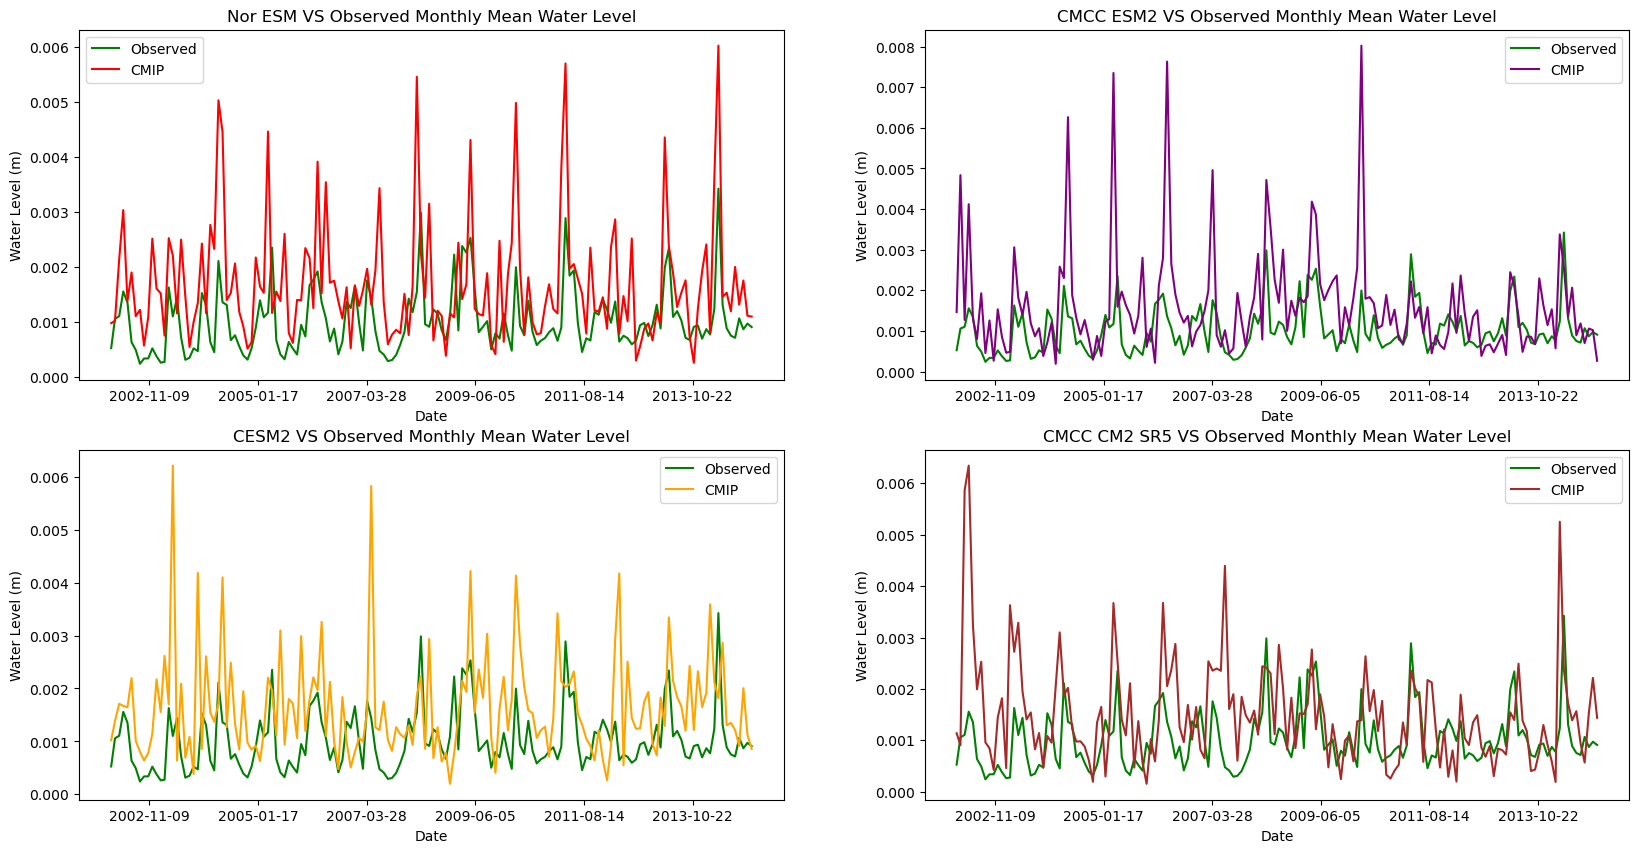

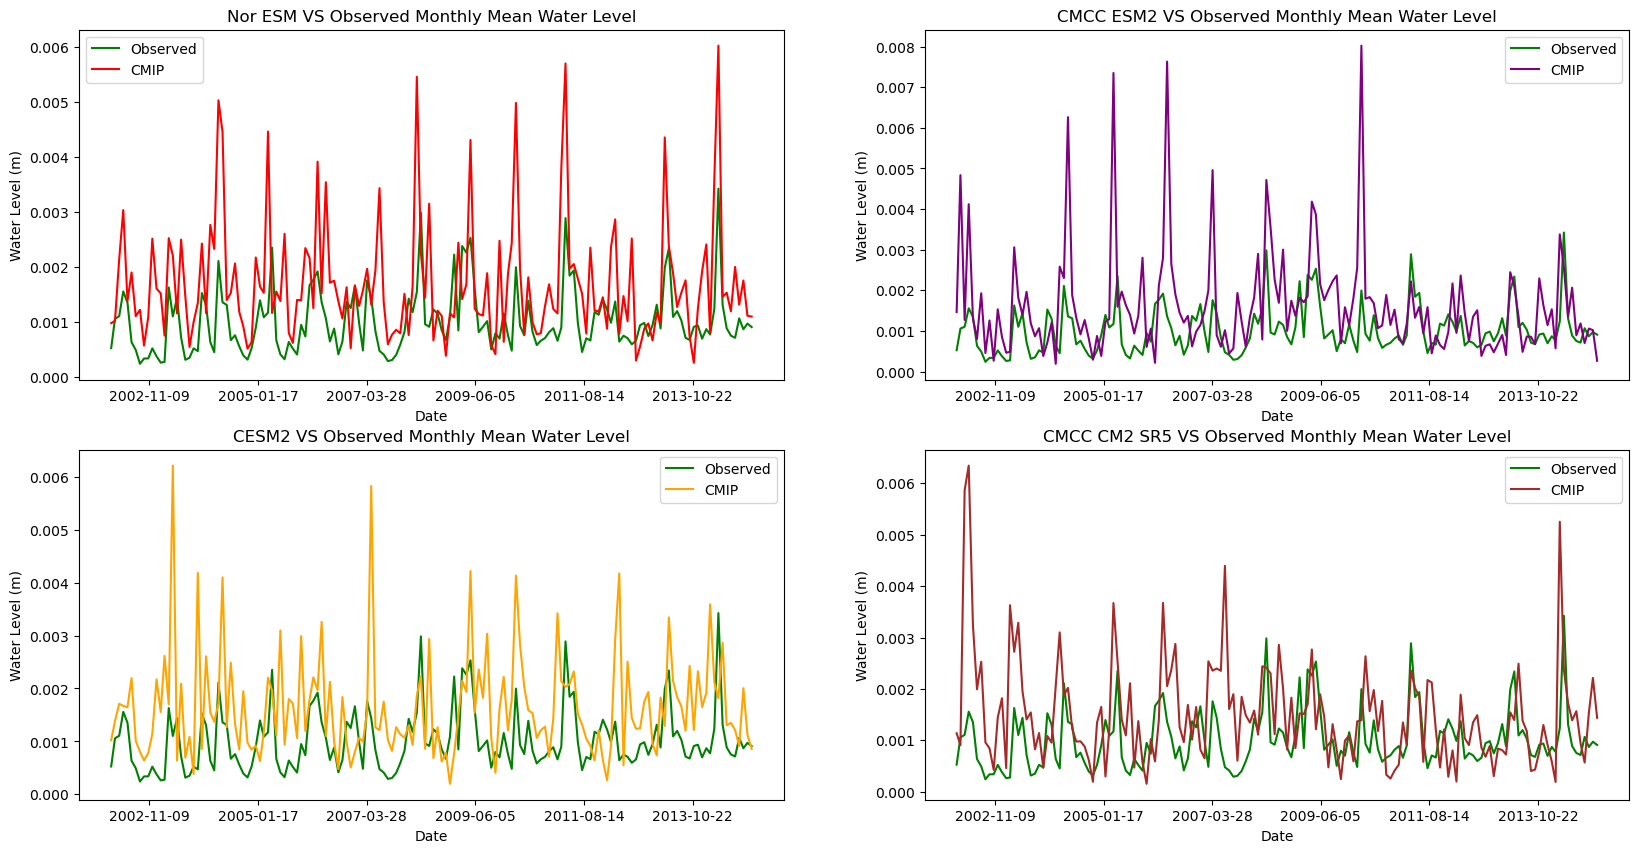

In [23]:
plt.close('all')
plt.rcParams["figure.figsize"] = (20,10)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(NorESM2_MM_585_and_Observed_Monthly['Date'],NorESM2_MM_585_and_Observed_Monthly['Water Level'], color="green",label='Observed')
ax1.plot(NorESM2_MM_585_and_Observed_Monthly['Date'],NorESM2_MM_585_and_Observed_Monthly['Water_Level'], color="red",label='CMIP')
ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.set_title('Nor ESM VS Observed Monthly Mean Water Level')
ax1.set_xlabel('Date')
ax1.set_ylabel('Water Level (m)')
ax1.legend()

ax2.plot(CMCC_ESM2_585_and_Observed_Monthly['Date'],CMCC_ESM2_585_and_Observed_Monthly['Water Level'], color="green",label='Observed')
ax2.plot(CMCC_ESM2_585_and_Observed_Monthly['Date'],CMCC_ESM2_585_and_Observed_Monthly['Water_Level'], color="purple",label='CMIP')
ax2.xaxis.set_major_locator(plt.MaxNLocator(8))
ax2.set_title('CMCC ESM2 VS Observed Monthly Mean Water Level')
ax2.set_xlabel('Date')
ax2.set_ylabel('Water Level (m)')
ax2.legend()

ax3.plot(CESM2_585_and_Observed_Monthly['Date'],CESM2_585_and_Observed_Monthly['Water Level'], color="green",label='Observed')
ax3.plot(CESM2_585_and_Observed_Monthly['Date'],CESM2_585_and_Observed_Monthly['Water_Level'], color="orange",label='CMIP')
ax3.xaxis.set_major_locator(plt.MaxNLocator(8))
ax3.set_title('CESM2 VS Observed Monthly Mean Water Level')
ax3.set_xlabel('Date')
ax3.set_ylabel('Water Level (m)')
ax3.legend()

ax4.plot(CMCC_CM2_SR5_585_and_Observed_Monthly['Date'],CMCC_CM2_SR5_585_and_Observed_Monthly['Water Level'], color="green",label='Observed')
ax4.plot(CMCC_CM2_SR5_585_and_Observed_Monthly['Date'],CMCC_CM2_SR5_585_and_Observed_Monthly['Water_Level'], color="brown",label='CMIP')
ax4.xaxis.set_major_locator(plt.MaxNLocator(8))
ax4.set_title('CMCC CM2 SR5 VS Observed Monthly Mean Water Level')
ax4.set_xlabel('Date')
ax4.set_ylabel('Water Level (m)')
ax4.legend()
fig

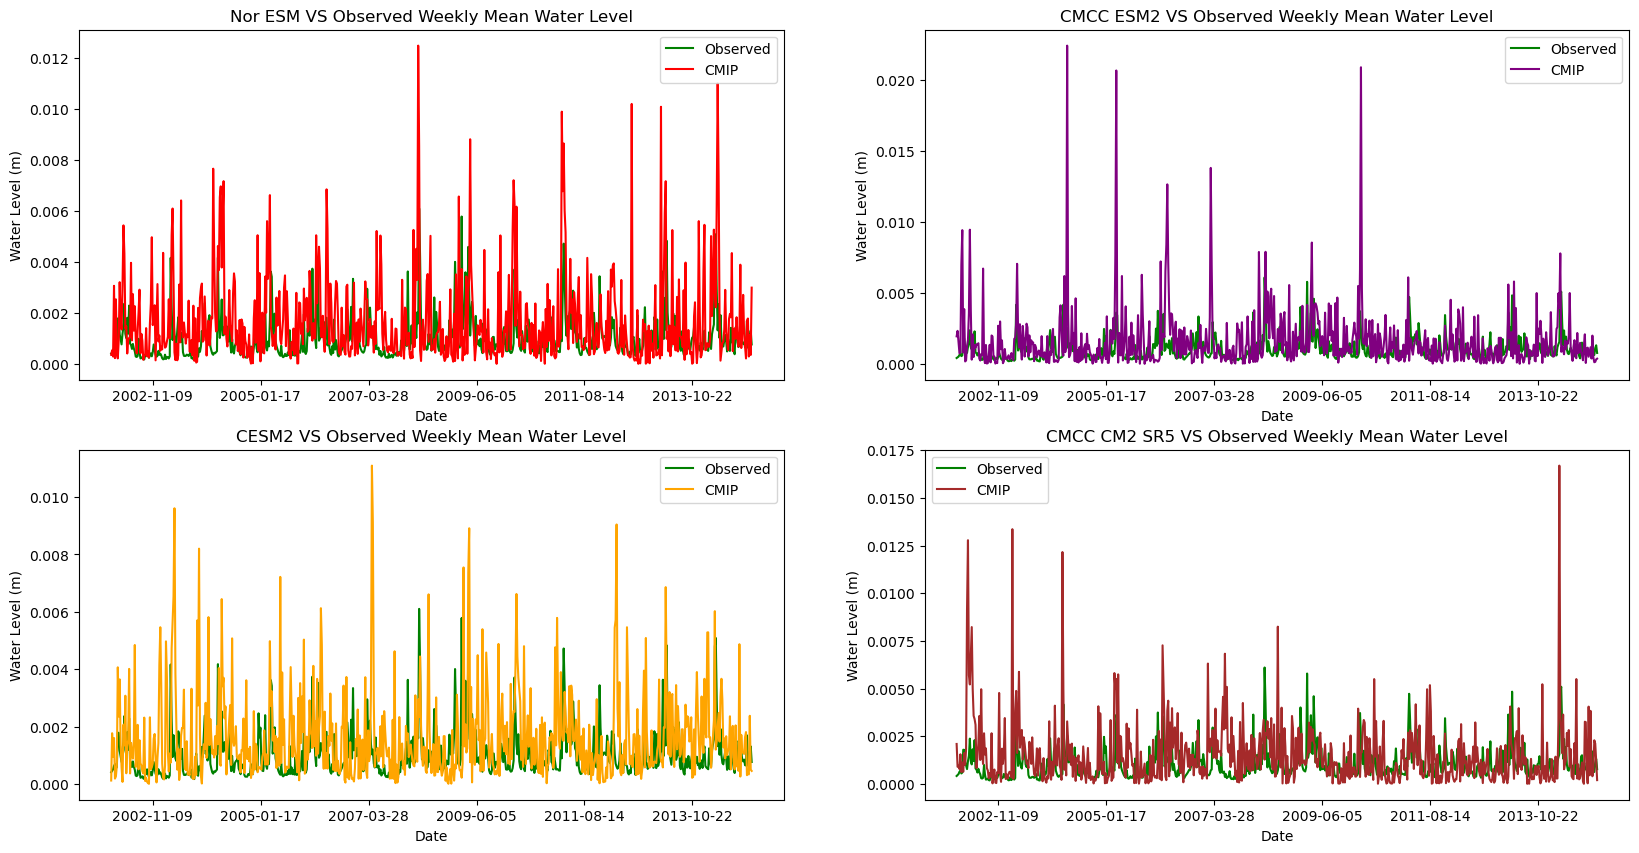

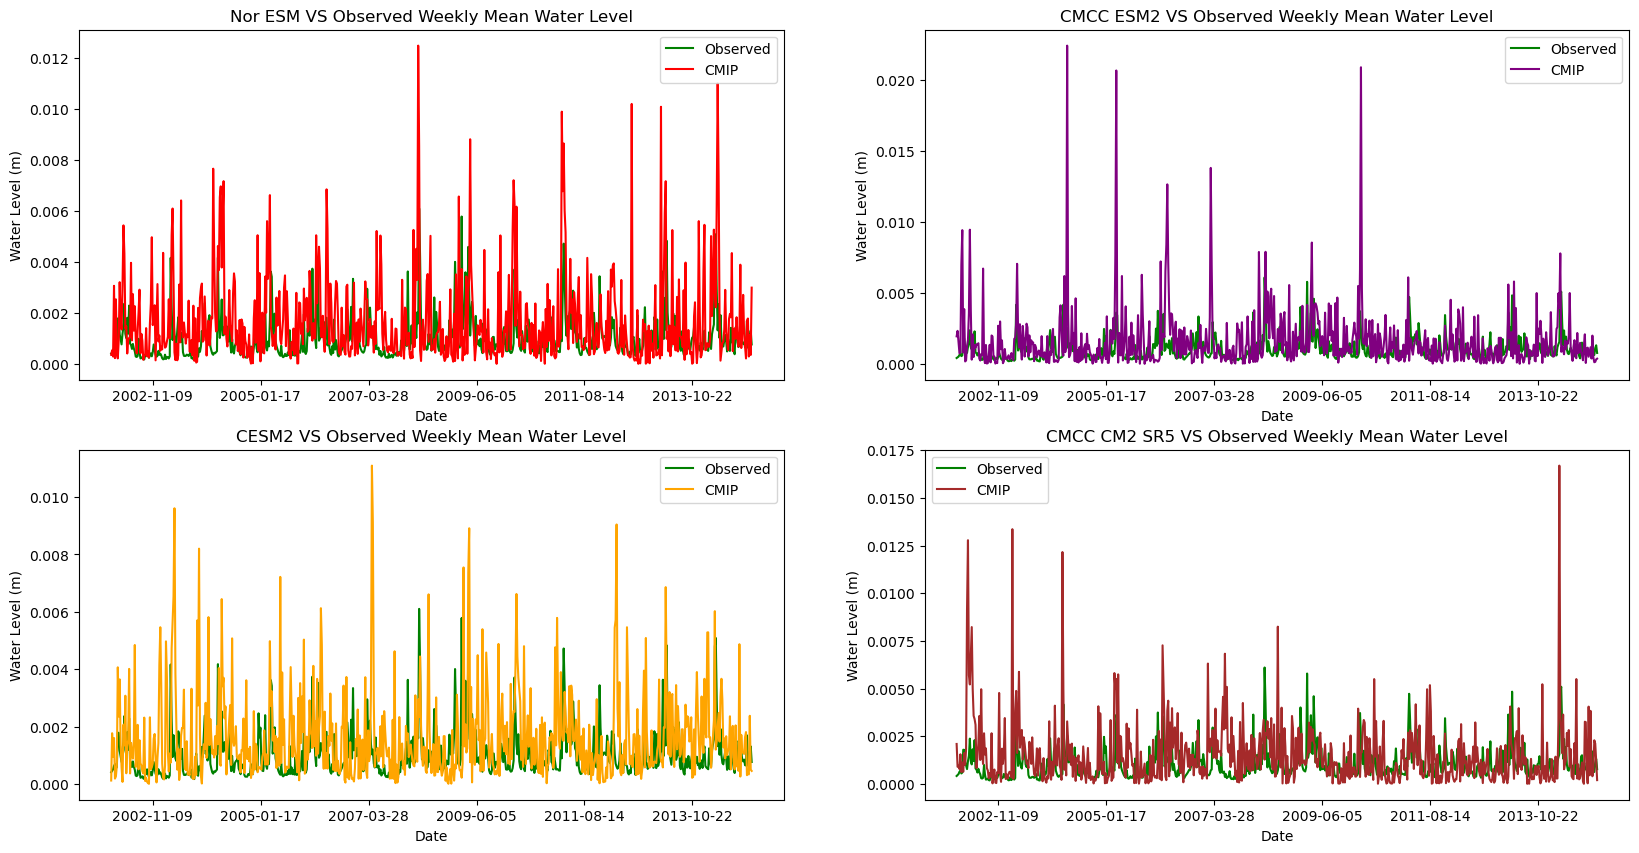

In [24]:
plt.close('all')
plt.rcParams["figure.figsize"] = (20,10)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(NorESM2_MM_585_and_Observed_Weekly['Date'],NorESM2_MM_585_and_Observed_Weekly['Water Level'], color="green",label='Observed')
ax1.plot(NorESM2_MM_585_and_Observed_Weekly['Date'],NorESM2_MM_585_and_Observed_Weekly['Water_Level'], color="red",label='CMIP')
ax1.xaxis.set_major_locator(plt.MaxNLocator(8))
ax1.set_title('Nor ESM VS Observed Weekly Mean Water Level')
ax1.set_xlabel('Date')
ax1.set_ylabel('Water Level (m)')
ax1.legend()

ax2.plot(CMCC_ESM2_585_and_Observed_Weekly['Date'],CMCC_ESM2_585_and_Observed_Weekly['Water Level'], color="green",label='Observed')
ax2.plot(CMCC_ESM2_585_and_Observed_Weekly['Date'],CMCC_ESM2_585_and_Observed_Weekly['Water_Level'], color="purple",label='CMIP')
ax2.xaxis.set_major_locator(plt.MaxNLocator(8))
ax2.set_title('CMCC ESM2 VS Observed Weekly Mean Water Level')
ax2.set_xlabel('Date')
ax2.set_ylabel('Water Level (m)')
ax2.legend()

ax3.plot(CESM2_585_and_Observed_Weekly['Date'],CESM2_585_and_Observed_Weekly['Water Level'], color="green",label='Observed')
ax3.plot(CESM2_585_and_Observed_Weekly['Date'],CESM2_585_and_Observed_Weekly['Water_Level'], color="orange",label='CMIP')
ax3.xaxis.set_major_locator(plt.MaxNLocator(8))
ax3.set_title('CESM2 VS Observed Weekly Mean Water Level')
ax3.set_xlabel('Date')
ax3.set_ylabel('Water Level (m)')
ax3.legend()

ax4.plot(CMCC_CM2_SR5_585_and_Observed_Weekly['Date'],CMCC_CM2_SR5_585_and_Observed_Weekly['Water Level'], color="green",label='Observed')
ax4.plot(CMCC_CM2_SR5_585_and_Observed_Weekly['Date'],CMCC_CM2_SR5_585_and_Observed_Weekly['Water_Level'], color="brown",label='CMIP')
ax4.xaxis.set_major_locator(plt.MaxNLocator(8))
ax4.set_title('CMCC CM2 SR5 VS Observed Weekly Mean Water Level')
ax4.set_xlabel('Date')
ax4.set_ylabel('Water Level (m)')
ax4.legend()
fig

In [25]:
StreamflowData2=StreamflowData2.drop(columns=['Outflow','Water Level'])
# Note: I remove the daily total outflow and water level. Water level was an idea that we had but ultimately chose not to use 
# variation in the dataset.

In [26]:
StreamflowData2.to_excel('Path\to\File\WaterLevel2023.xlsx')